In [1]:
'''
Now we try to see if we can find more affordable players with statistica comparable to the winners of the league
'''

In [10]:
#1. We load data of the winners, the whole dataset and the important variables

import pandas as pd
import numpy as np

winners = pd.read_csv("Winners/1_league_winners_ref.csv")
players = pd.read_csv("../01_Datasets/Players Statistics/data_2/Final Datasets/Parametrized/Final_df_players_Parametrized.csv")
keepers = pd.read_csv("../01_Datasets/Players Statistics/data_2/Final Datasets/Parametrized/Final_df_keepers_Parametrized.csv")
variables_per_role = open("../02_Machine Learning/Variables per role.txt",'r')

In [13]:
new_roles = ['Centre-Back', 'Full-Back', 'Midfielder', 'Striker', 'Winger']

role_dictionary = {'Attacking Midfield' : new_roles[2], 
                   'Central Midfield' : new_roles[2], 
                   'Centre-Back' : new_roles[0],
                   'Centre-Forward' : new_roles[3],
                   'Defensive Midfield' : new_roles[2], 
                   'Left Midfield' : new_roles[4],
                   'Left Winger' : new_roles[4], 
                   'Left-Back' : new_roles[1],  
                   'Right Midfield' : new_roles[4], 
                   'Right Winger' : new_roles[4],
                   'Right-Back' : new_roles[1], 
                   'Second Striker' : new_roles[3]}

players['Gen_Pos'] = players['Position'].map(role_dictionary)
keepers['Gen_Pos'] = keepers['Position']
players = players.drop(['Position'], axis = 1)
keepers = keepers.drop(['Position'], axis = 1)

In [14]:
contents = variables_per_role.read()
print(contents)

Variables per role
Keepers, Goals.Against, Saves, Save., PSxG.SoT, PSxG.GA, Clean.Sheet.Percentage, Penalty.Kicks.Attempted, PSxG
Centre-Backs, Shots.on.target, Pass.Completion....Medium., Pass.Completion....Long., Passes.Attempted..Head., Successful.Pressure.., Touches..Def.Pen., Touches..Att.Pen., Passes.Received.., Ball.Recoveries, Aerials.won, Aerials.lost, X..of.Aerials.Won
Full-Backs, npxG, Pass.Completion.., Passes.Completed..Short., Pass.Completion....Short., Pass.Completion....Medium., Pass.Completion....Long., Touches..Att.Pen., Passes.Received.., Ball.Recoveries
Midfielders, Non.Penalty.Goals, npxG, Shots.on.target.., Pass.Completion.., Pass.Completion....Short., Pass.Completion....Medium., GCA..PassLive., Successful.Pressure.., Touches..Att.Pen., Passes.Received..
Wingers, Goals, Non.Penalty.Goals, xG, npxG, npxG.xA, Shots.Total, Shots.on.target, Shots.on.target.., Goals.Shot, Pass.Completion.., Pass.Completion....Short., Pass.Completion....Medium., Goal.Creating.Actions, G

In [15]:
dictionary_of_vars = {
    'Goalkeeper' : ['Goals.Against', 'Saves', 'Save.', 'PSxG.SoT', 'PSxG.GA', 
                    'Clean.Sheet.Percentage', 'Penalty.Kicks.Attempted', 'PSxG'],
    'Centre-Back' : ['Shots.on.target', 'Pass.Completion....Medium.', 'Pass.Completion....Long.', 'Passes.Attempted..Head.',
                     'Successful.Pressure..', 'Touches..Def.Pen.', 'Touches..Att.Pen.', 'Passes.Received..', 'Ball.Recoveries',
                     'Aerials.won', 'Aerials.lost', 'X..of.Aerials.Won'],
    'Full-Back' : ['npxG', 'Pass.Completion..', 'Passes.Completed..Short.', 'Pass.Completion....Short.', 
                   'Pass.Completion....Medium.', 'Pass.Completion....Long.', 'Touches..Att.Pen.', 'Passes.Received..', 
                   'Ball.Recoveries'], 
    'Midfielder' : ['Non.Penalty.Goals', 'npxG', 'Shots.on.target..', 'Pass.Completion..', 'Pass.Completion....Short.',
                    'Pass.Completion....Medium.', 'GCA..PassLive.', 'Successful.Pressure..', 'Touches..Att.Pen.',
                    'Passes.Received..'],
    'Striker' : ['Goals', 'Assists', 'Non.Penalty.Goals', 'xG', 'npxG', 'npxG.xA', 'Shots.Total', 'Shots.on.target',
                 'Shots.on.target..', 'Goals.Shot', 'Pass.Completion..', 'Pass.Completion....Short.', 
                 'Pass.Completion....Medium.', 'GCA..PassLive.', 'Successful.Pressure..', 'Touches..Att.Pen.', 'Pass.Targets',
                 'Fouls.Committed'],
    'Winger' : ['Goals', 'Non.Penalty.Goals', 'xG', 'npxG', 'npxG.xA', 'Shots.Total', 'Shots.on.target', 'Shots.on.target..', 
                'Goals.Shot','Pass.Completion..', 'Pass.Completion....Short.', 'Pass.Completion....Medium.',
                'Goal.Creating.Actions', 'GCA..PassLive.', 'Touches..Att.Pen.']
}

In [16]:
#3. Let's try to build a function which will output the low-cost players

def low_cost_winners(season, league, save_on_the_budget):
    
    winners_league_year = winners[(winners['League'] == league) & (winners['Season'] == season)]
    substitutes = []
    
    for i in range(len(list(dictionary_of_vars.keys()))):
        
        players_ref = pd.DataFrame()
        keepers_ref = pd.DataFrame()
        pla = pd.DataFrame()
        tot = pd.DataFrame()
    
        if list(dictionary_of_vars.keys())[i] == "Goalkeeper":
        
            keepers_ref = keepers[['Player_SN', 'scouting_period', 'Data_League', 'Gen_Pos', 'Player Valuation'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]]
            keepers_ref = keepers_ref[(keepers_ref['scouting_period'] == season)]#&(keepers_ref['Data_League'] == league)]
            
            pla = winners_league_year[winners_league_year['Gen_Pos'] == list(dictionary_of_vars.keys())[i]]
            
            tot = pd.merge(keepers_ref, pla, left_on = ['Player_SN', 'Data_League', 'scouting_period', 'Gen_Pos'],
               right_on = ['Player','League','Season','Gen_Pos']).drop(['Player','League','Season'], axis = 1)
            tot2 = tot.drop("Player Valuation", axis = 1)
            important_values = tot2.mean(numeric_only=True)
            
            diff_df = keepers_ref[dictionary_of_vars[list(dictionary_of_vars.keys())[i]]] - tot2.mean(numeric_only=True).values
            norm_df = diff_df.apply(np.linalg.norm, axis=1)
            norm_df = pd.DataFrame(norm_df[norm_df!=0])
            norm_df.columns = ['Similarity']
            
            sim_df = norm_df.join(keepers_ref[['Player_SN','Player Valuation', 'Gen_Pos'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]][(keepers_ref['Player Valuation'] <= (np.mean(tot['Player Valuation'])/save_on_the_budget))&(keepers_ref['Gen_Pos'] == np.unique(tot['Gen_Pos'])[0])]).dropna()
            #sim_df = sim_df[~sim_df['Player_SN'].isin(tot['Player_SN'])].dropna()
            for pp in sim_df.sort_values(by = ['Similarity'], ascending = True)[:len(tot)][['Similarity','Player_SN','Player Valuation', 'Gen_Pos']].values.tolist():
                substitutes.append(pp)
        
        else:
        
            players_ref = players[['Player_SN', 'scouting_period', 'Data_League', 'Gen_Pos', 'Player Valuation'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]]
            players_ref = players_ref[(players_ref['scouting_period'] == season)]#&(players_ref['Data_League'] == league)]
            
            pla = winners_league_year[winners_league_year['Gen_Pos'] == list(dictionary_of_vars.keys())[i]]
            
            tot = pd.merge(players_ref, pla, left_on = ['Player_SN', 'Data_League', 'scouting_period', 'Gen_Pos'],
               right_on = ['Player','League','Season','Gen_Pos']).drop(['Player','League','Season'], axis = 1)
            tot2 = tot.drop("Player Valuation", axis = 1)
            important_values = tot2.mean(numeric_only=True)
            
            diff_df = players_ref[dictionary_of_vars[list(dictionary_of_vars.keys())[i]]] - tot2.mean(numeric_only=True).values
            norm_df = diff_df.apply(np.linalg.norm, axis=1)
            norm_df = pd.DataFrame(norm_df[norm_df!=0])
            norm_df.columns = ['Similarity']
            
            sim_df = norm_df.join(players_ref[['Player_SN','Player Valuation', 'Gen_Pos'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]][(players_ref['Player Valuation'] <= (np.mean(tot['Player Valuation'])/save_on_the_budget))&(players_ref['Gen_Pos'] == np.unique(tot['Gen_Pos'])[0])]).dropna()
            #sim_df = sim_df[~sim_df['Player_SN'].isin(tot['Player_SN'])].dropna()
            for pp in sim_df.sort_values(by = ['Similarity'], ascending = True)[:len(tot)][['Similarity','Player_SN','Player Valuation', 'Gen_Pos']].values.tolist():
                substitutes.append(pp)
    
    datasim = pd.DataFrame(substitutes)
    datasim.columns = ['Similarity', 'Player', 'Player Valuation', 'Position']
    
    return datasim

In [17]:
#Let's check which league has the best trade off between savings and similarity coefficient

seasons = ['2017-2018','2018-2019','2019-2020','2020-2021']
leagues = ['Premier League','Serie A','Ligue 1','Bundesliga','La Liga']
total_players = pd.concat([players[['Player_SN', 'Data_League','scouting_period','Gen_Pos', 'Player Valuation']], 
                           keepers[['Player_SN', 'Data_League','scouting_period','Gen_Pos', 'Player Valuation']]],
                           ignore_index = True)

sim = []
for i in range(len(seasons)):
    for j in range(len(leagues)):
        
        winners_league_year = winners[(winners['League'] == leagues[j]) & (winners['Season'] == seasons[i])]
        
        tot = pd.merge(total_players, winners_league_year, left_on = ['Player_SN', 'Data_League', 'scouting_period', 'Gen_Pos'],
               right_on = ['Player','League','Season','Gen_Pos'])
        
        sim.append([seasons[i], 
                    leagues[j],
                    np.mean(low_cost_winners(seasons[i], leagues[j], 2)['Similarity']),
                    (100 - (np.sum(low_cost_winners(seasons[i], leagues[j], 2)['Player Valuation']) / np.sum(tot['Player Valuation']))*100)])
        
coeff = pd.DataFrame(sim)
coeff.columns = ['Season','League','Similarity Coeff.', 'Savings']
coeff['Trade Off'] = coeff['Savings'] / coeff['Similarity Coeff.']
coeff.sort_values(by = ['Trade Off'], ascending = False, inplace = True)
coeff = coeff.reset_index().drop(['index'], axis = 1)
coeff

,Season,League,Similarity Coeff.,Savings,Trade Off
0,2020-2021,Serie A,4.424397,74.685169,16.880303
1,2020-2021,Ligue 1,4.480457,75.257386,16.796812
2,2019-2020,Serie A,5.254009,80.591059,15.338965
3,2020-2021,Bundesliga,5.364341,82.053054,15.296018
4,2018-2019,Ligue 1,5.763644,84.111916,14.593531
5,2017-2018,Ligue 1,5.853028,84.277549,14.398966
6,2018-2019,Serie A,4.960894,70.858656,14.283444
7,2019-2020,Premier League,5.621322,80.103230,14.249892
8,2019-2020,Bundesliga,5.533250,77.829621,14.065806
9,2019-2020,Ligue 1,6.021776,80.735139,13.407198


In [18]:
low_cost_winners('2020-2021', 'Serie A', 2)

,Similarity,Player,Player Valuation,Position
0,4.293194,Claudio Bravo,1000000.0,Goalkeeper
1,3.511304,Niklas Stark,10750000.0,Centre-Back
2,3.824119,Amir Rrahmani,13333333.0,Centre-Back
3,4.419091,Jordan Torunarigha,11333333.0,Centre-Back
4,2.988132,Bruno Peres,2666666.0,Full-Back
5,3.917845,Andrea Conti,7166666.0,Full-Back
6,3.961353,Maxime Busi,4250000.0,Full-Back
7,5.423287,Óscar De Marcos,2333333.0,Full-Back
8,3.433324,Roberto Gagliardini,14666666.0,Midfielder
9,3.889508,Jasmin Kurtič,2833333.0,Midfielder


In [9]:
from collections import Counter

ripetizioni = []

for i in range(len(seasons)):
    giocatori_della_season = []
    for j in range(len(leagues)):
        data = low_cost_winners(seasons[i], leagues[j], 2)
        giocatori_della_season.append([i for i in data['Player']])
    giocatori_della_season = [item for sublist in giocatori_della_season for item in sublist]
    giocatori_della_season = list(set(giocatori_della_season))
    ripetizioni.append(giocatori_della_season)
        
ripetizioni = [item for sublist in ripetizioni for item in sublist]

In [10]:
from collections import Counter, OrderedDict

x = Counter(ripetizioni)
y = OrderedDict(x.most_common())

y

OrderedDict([('Franck Ribéry', 3),
             ('Gerard Moreno', 3),
             ('Otávio', 3),
             ('Łukasz Piszczek', 2),
             ('Nacho Monreal', 2),
             ('Patrik Schick', 2),
             ('Andriy Yarmolenko', 2),
             ('Julian Baumgartlinger', 2),
             ('Iago Aspas', 2),
             ('Vincent Kompany', 2),
             ('Timothy Castagne', 2),
             ('Pione Sisto', 2),
             ('Karim Bellarabi', 2),
             ('Márcio Rafael Ferreira de Souza', 2),
             ('Juanmi', 2),
             ('Pierre Højbjerg', 2),
             ('Bouna Sarr', 2),
             ("Nicolas N'Koulou", 2),
             ('Christoph Kramer', 2),
             ('Antonio Barragán', 2),
             ('Christophe Jallet', 2),
             ('Juan Foyth', 2),
             ('Vincenzo Grifo', 2),
             ('Rogério', 2),
             ('Stefan Mitrović', 2),
             ('Jason Denayer', 2),
             ('Francesco Acerbi', 2),
             ('Patrick van

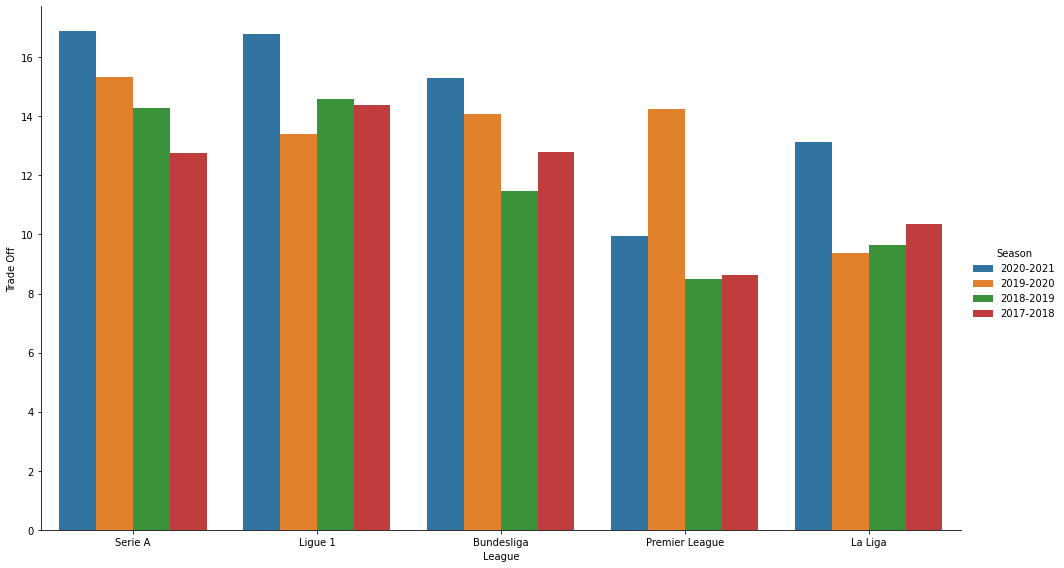

In [11]:
import seaborn as sns

g = sns.catplot(x="League", y="Trade Off",
                hue="Season",data=coeff, kind="bar",
                height=8, aspect=1.7)

g

In [11]:
lower, upper = 0.14, 0.40
l_norm = [lower + (upper - lower) * x for x in keepers['avg_playerankIndex']]
keepers['avg_playerankIndex'] = l_norm

final_data = pd.concat([players,keepers], ignore_index = True)
final_data = final_data.sort_values(by = ['Player_SN',"scouting_period"])

In [12]:
new_roles = ['Goalkeeper','Centre-Back', 'Full-Back', 'Midfielder', 'Striker', 'Winger']

role_dictionary = {'Attacking Midfield' : new_roles[3], 
                   'Central Midfield' : new_roles[3], 
                   'Centre-Back' : new_roles[1],
                   'Centre-Forward' : new_roles[4],
                   'Defensive Midfield' : new_roles[3], 
                   'Left Midfield' : new_roles[5],
                   'Left Winger' : new_roles[5], 
                   'Left-Back' : new_roles[2],  
                   'Right Midfield' : new_roles[5], 
                   'Right Winger' : new_roles[5],
                   'Right-Back' : new_roles[2], 
                   'Second Striker' : new_roles[4],
                   'Goalkeeper': new_roles[0]}

final_data["Gen_Pos"] = final_data['Position'].map(role_dictionary)
final_data['trial'] = final_data[['Player_LN', 'scouting_period']].agg(', '.join, axis=1)

new1 = pd.Series(dtype = 'object')
for i in new_roles:
    new = pd.concat([pd.Series([final_data.loc[final_data['Gen_Pos'] == i,'avg_playerankIndex'].min()-0.001]), final_data.loc[final_data['Gen_Pos'] == i,'avg_playerankIndex']], ignore_index = False)
    new = (new-new.min())/(new.max()-new.min())
    new = new[new != 0]
    new1 = pd.concat([new1, new], ignore_index = False)

new1 = new1.sort_index(ascending = True)
final_data['NormInd'] = new1

final_data['PVS'] = final_data['Player Valuation']**0.3

final_data['Likability'] = 10*((final_data['NormInd']*100)**1.70/final_data["PVS"])

In [21]:
low_cost = low_cost_winners('2020-2021', 'Serie A', 2)
low_cost['Season'] = '2020-2021'
low_cost

,Similarity,Player,Player Valuation,Position,Season
0,4.293194,Claudio Bravo,1000000.0,Goalkeeper,2020-2021
1,3.511304,Niklas Stark,10750000.0,Centre-Back,2020-2021
2,3.824119,Amir Rrahmani,13333333.0,Centre-Back,2020-2021
3,4.419091,Jordan Torunarigha,11333333.0,Centre-Back,2020-2021
4,2.988132,Bruno Peres,2666666.0,Full-Back,2020-2021
5,3.917845,Andrea Conti,7166666.0,Full-Back,2020-2021
6,3.961353,Maxime Busi,4250000.0,Full-Back,2020-2021
7,5.423287,Óscar De Marcos,2333333.0,Full-Back,2020-2021
8,3.433324,Roberto Gagliardini,14666666.0,Midfielder,2020-2021
9,3.889508,Jasmin Kurtič,2833333.0,Midfielder,2020-2021


In [23]:
vincitori = winners[(winners['League']=="Serie A")&(winners['Season'] == "2020-2021")]
vincitori = vincitori.reset_index().drop(['index'], axis = 1)
vincitori

,Player,League,Season,Gen_Pos
0,Samir Handanovič,Serie A,2020-2021,Goalkeeper
1,Alessandro Bastoni,Serie A,2020-2021,Centre-Back
2,Nicolò Barella,Serie A,2020-2021,Midfielder
3,Romelu Lukaku,Serie A,2020-2021,Striker
4,Milan Škriniar,Serie A,2020-2021,Centre-Back
5,Stefan de Vrij,Serie A,2020-2021,Centre-Back
6,Lautaro Martínez,Serie A,2020-2021,Striker
7,Achraf Hakimi,Serie A,2020-2021,Full-Back
8,Marcelo Brozović,Serie A,2020-2021,Midfielder
9,Ivan Perišić,Serie A,2020-2021,Winger


In [32]:
aa = pd.merge(final_data[['Player_SN',"Player Valuation","Gen_Pos",'scouting_period', 'Likability','avg_playerankIndex']], 
              low_cost, 
              left_on = ['Player_SN',"Player Valuation","Gen_Pos",'scouting_period'],
              right_on = ['Player','Player Valuation','Position','Season'])

aa = aa.drop(['Player','Position','Season'], axis = 1)

bb = pd.merge(final_data[['Player_SN',"Data_League","scouting_period",'Gen_Pos', 'Likability','avg_playerankIndex']], 
              vincitori, 
              left_on = ['Player_SN',"Data_League","scouting_period",'Gen_Pos'],
              right_on = ['Player','League','Season','Gen_Pos'])

bb = bb.drop(['Player','League','Season'], axis = 1)

In [37]:
print(sum(aa['avg_playerankIndex']))
print(sum(bb['avg_playerankIndex']))
print(sum(aa['Likability']))
print(sum(bb['Likability']))

2.9557771389439704
3.027599453874126
957.3753617322143
851.2699704167111


In [38]:
aa

,Player_SN,Player Valuation,Gen_Pos,scouting_period,Likability,avg_playerankIndex,Similarity
0,Amir Rrahmani,13333333,Centre-Back,2020-2021,34.159215,0.162290,3.824119
1,Andrea Conti,7166666,Full-Back,2020-2021,45.104244,0.152780,3.917845
2,Bruno Peres,2666666,Full-Back,2020-2021,87.952207,0.158335,2.988132
3,Claudio Bravo,1000000,Goalkeeper,2020-2021,91.295430,0.180653,4.293194
4,Danilo Cataldi,2900000,Midfielder,2020-2021,22.942632,0.147942,6.038868
5,Ivan Ilić,5333333,Midfielder,2020-2021,39.950831,0.157987,5.765697
6,Jasmin Kurtič,2833333,Midfielder,2020-2021,53.943841,0.159904,3.889508
7,Jordan Torunarigha,11333333,Centre-Back,2020-2021,50.985829,0.167252,4.419091
8,Karim Bellarabi,5750000,Winger,2020-2021,15.072659,0.158734,3.847888
9,Marko Rog,11666666,Midfielder,2020-2021,40.488440,0.162473,5.068749


In [39]:
bb

,Player_SN,Data_League,scouting_period,Gen_Pos,Likability,avg_playerankIndex
0,Achraf Hakimi,Serie A,2020-2021,Full-Back,68.800841,0.171602
1,Alessandro Bastoni,Serie A,2020-2021,Centre-Back,23.698138,0.162876
2,Alexis Sánchez,Serie A,2020-2021,Striker,38.667656,0.177333
3,Arturo Vidal,Serie A,2020-2021,Midfielder,40.750353,0.159644
4,Ashley Young,Serie A,2020-2021,Full-Back,126.064619,0.162508
5,Christian Eriksen,Serie A,2020-2021,Midfielder,22.299276,0.159098
6,Danilo D'Ambrosio,Serie A,2020-2021,Full-Back,77.712431,0.161741
7,Ivan Perišić,Serie A,2020-2021,Winger,13.480102,0.159996
8,Lautaro Martínez,Serie A,2020-2021,Striker,25.548435,0.180974
9,Marcelo Brozović,Serie A,2020-2021,Midfielder,28.523896,0.163026


In [44]:
plpl = players[(players['Data_League'] == "Serie A")&(players['scouting_period'] == "2020-2021")].sort_values(by=['avg_playerankIndex'], ascending = False)
plpl[0:18]

,Player_SN,Player_LN,avg_playerankIndex,Player Valuation,scouting_period,Age,Height,Foot,Data_League,Goals,...,Fouls.Drawn,Offsides,Penalty.Kicks.Won,Penalty.Kicks.Conceded,Own.Goals,Ball.Recoveries,Aerials.won,Aerials.lost,X..of.Aerials.Won,Gen_Pos
4675,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,0.199820,53750000,2020-2021,37.0,1.87,right,Serie A,0.841049,...,1.483140,1.105762,0.054261,0.000000,0.0,3.662633,0.841049,0.605917,52.452519,Striker
6127,Romelu Lukaku,Romelu Lukaku Menama,0.196615,91666666,2020-2021,29.0,1.91,left,Serie A,0.678265,...,1.492184,0.652400,0.000000,0.000000,0.0,2.459842,1.040007,1.745403,33.822831,Striker
4276,Zlatan Ibrahimović,Zlatan Ibrahimović,0.193890,4166666,2020-2021,40.0,1.95,both,Serie A,0.813918,...,1.474097,2.664886,0.108522,0.000000,0.0,3.436544,4.033418,2.450799,56.250805,Striker
1524,Henrikh Mkhitaryan,Henrikh Mkhitaryan,0.192240,18333333,2020-2021,33.0,1.77,both,Serie A,0.388872,...,1.718272,0.364901,0.027131,0.000000,0.0,6.348564,0.470264,0.949571,30.114981,Midfielder
5582,Luis Muriel,Luis Fernando Muriel Fruto,0.184830,25000000,2020-2021,31.0,1.79,right,Serie A,1.248008,...,1.419835,0.276440,0.054261,0.000000,0.0,5.380905,1.528358,2.776366,32.104559,Striker
4840,Duván Zapata,Duván Esteban Zapata Banguera,0.184010,37000000,2020-2021,31.0,1.89,right,Serie A,0.515482,...,1.917230,0.873552,0.036174,0.000000,0.0,3.318978,1.365574,2.667844,30.657593,Striker
986,Domenico Berardi,Domenico Berardi,0.182641,29666666,2020-2021,27.0,1.83,left,Serie A,0.560699,...,2.269928,0.121634,0.036174,0.000000,0.0,5.688385,0.361742,0.985746,24.236681,Winger
729,Ciro Immobile,Ciro Immobile,0.182250,42666666,2020-2021,32.0,1.85,right,Serie A,0.569743,...,1.311313,1.050474,0.081392,0.000000,0.0,4.313768,0.741570,1.600706,28.668015,Striker
6386,Victor Osimhen,Victor James Osimhen,0.181464,47500000,2020-2021,23.0,1.86,right,Serie A,0.515482,...,1.862969,1.260569,0.054261,0.000000,0.0,2.794453,1.917230,3.309935,33.099348,Striker
1190,Federico Chiesa,Federico Chiesa,0.181378,54000000,2020-2021,24.0,1.75,right,Serie A,0.298437,...,1.492184,0.530766,0.063305,0.000000,0.0,5.019163,0.235132,1.166616,15.102708,Winger


In [45]:
max(plpl['avg_playerankIndex'])

0.1998203862832632

In [48]:
plpl['avg_playerankIndex'].std()

0.008349601392633261

In [49]:
2.9557771389439704+0.008349601392633261

2.964126740336604